In [1]:
import dask.dataframe as dd
from dask.distributed import Client

c = Client('localhost:8786')

In [2]:
c.restart()

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787,Cluster Workers: 4 Cores: 4 Memory: 10.03 GB


In [3]:
import numpy as np
import pandas as pd

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

import seaborn.apionly as sns
from matplotlib import rcParams

import matplotlib.dates as mdates
from matplotlib.colors import SymLogNorm as symlog

In [5]:
plt.style.use('seaborn-darkgrid')

rcParams['font.sans-serif'] = ('Helvetica', 'Arial', 'Open Sans', 'Bitstream Vera Sans')
rcParams['font.size'] = 10
rcParams['font.stretch'] = 'normal'
rcParams['font.weight'] = 'normal'
rcParams['axes.titlesize'] = 11

rcParams['savefig.dpi'] = 150
rcParams['figure.dpi'] = 150

rcParams['grid.color'] = 'w'
rcParams['grid.alpha'] = 0.7

rcParams['xtick.direction'] = 'out'
rcParams['xtick.major.size'] = 3
rcParams['ytick.direction'] = 'out'
rcParams['ytick.major.size'] = 3




import os.path
homedirpath = os.path.expanduser('~')
fontdirpath = ''
if '/Users/' in homedirpath:
    fontdirpath = os.path.join(homedirpath, 'Library/Fonts/')
else:
    fontdirpath = os.path.join(homedirpath, '.fonts/')
fontsize2 = 'size={0:0.1f}'.format(12)
rcParams['mathtext.it'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaOblique.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.rm'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.tt'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.bf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaBold.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.cal'] = ((':family=sans-serif:style=normal:variant='
                             'normal:weight=normal:stretch=normal:file='
                             '{0}/Helvetica.ttf:' +
                             fontsize2
                             ).format(fontdirpath))
rcParams['mathtext.sf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))

# Pickups

In [6]:
pickups = dd.read_parquet('/data/all_trips_spark.parquet', engine='arrow', 
                        columns=['pickup_datetime', 'pickup_taxizone_id', 'trip_type'])
pickups = pickups[pickups.trip_type != 'uber']

In [7]:
pickups = pickups.drop('trip_type', axis=1)

In [8]:
pickups.columns = ['t', 'id']

In [9]:
# Rounded to nearest 6 minutes (0.1 hour) for easier aggregation
pickups['timeofday'] = (pickups.t.dt.hour + (pickups.t.dt.minute // 6)/10)

In [10]:
pickups['dayofweek'] = pickups.t.dt.dayofweek
# pickups['weekofyear'] = pickups.t.dt.weekofyear
pickups['weeks_since_2009'] = (pickups.t - np.datetime64('2009-01-01 00:00:00').astype('<M8[ns]')).astype('timedelta64[W]').astype('i4')

In [11]:
def isbusday(d):
    return np.is_busday(d.t.values.astype('<M8[D]')).astype(int)

pickups['isbusday'] = pickups.map_partitions(isbusday, meta=(None, int))

In [12]:
pickups = pickups[(pickups.isbusday == 1) | (pickups.dayofweek > 4)]

In [13]:
pickups.tail()

,t,id,timeofday,dayofweek,weeks_since_2009,isbusday
1432504,2016-12-31 23:59:57,36,23.9,5,417,0
1432505,2016-12-31 23:59:58,76,23.9,5,417,0
1432506,2016-12-31 23:59:58,168,23.9,5,417,0
1432507,2016-12-31 23:59:58,144,23.9,5,417,0
1432508,2016-12-31 23:59:59,135,23.9,5,417,0


In [14]:
heatmap_all_pickups = pickups[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().groupby(['dayofweek', 'timeofday']).mean().compute().reset_index()
heatmap_all_pickups_std = pickups[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().compute().groupby(['dayofweek', 'timeofday']).std().reset_index()

In [15]:
heatmap_all_pickups.sort_values(['dayofweek', 'timeofday'], inplace=True)
heatmap_all_pickups_std.sort_values(['dayofweek', 'timeofday'], inplace=True)

# Dropoffs

In [16]:
dropoffs = dd.read_parquet('/data/all_trips_spark.parquet', engine='arrow', 
                        columns=['dropoff_datetime', 'dropoff_taxizone_id', 'trip_type'])
dropoffs = dropoffs[dropoffs.trip_type != 'uber']

In [17]:
dropoffs = dropoffs.drop('trip_type', axis=1)

In [18]:
dropoffs.columns = ['t', 'id']

In [19]:
# Rounded to nearest 6 minutes (0.1 hour) for easier aggregation
dropoffs['timeofday'] = (dropoffs.t.dt.hour + (dropoffs.t.dt.minute // 6)/10)

In [20]:
dropoffs['dayofweek'] = dropoffs.t.dt.dayofweek
# pickups['weekofyear'] = pickups.t.dt.weekofyear
dropoffs['weeks_since_2009'] = (dropoffs.t - np.datetime64('2009-01-01 00:00:00').astype('<M8[ns]')).astype('timedelta64[W]').astype('i4')

In [21]:
def isbusday(d):
    return np.is_busday(d.t.values.astype('<M8[D]')).astype(int)

dropoffs['isbusday'] = dropoffs.map_partitions(isbusday, meta=(None, int))

In [22]:
dropoffs.tail()

,t,id,timeofday,dayofweek,weeks_since_2009,isbusday
1432504,2017-01-01 00:07:47,36,0.1,6,417,0
1432505,2017-01-01 00:15:29,63,0.2,6,417,0
1432506,2017-01-01 00:39:07,161,0.6,6,417,0
1432507,2017-01-01 00:03:50,209,0.0,6,417,0
1432508,2017-01-01 00:14:30,134,0.2,6,417,0


In [32]:
heatmap_all_dropoffs = dropoffs[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().groupby(['dayofweek', 'timeofday']).mean().compute().reset_index()
heatmap_all_dropoffs_std = dropoffs[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().compute().groupby(['dayofweek', 'timeofday']).std().reset_index()

In [33]:
heatmap_all_dropoffs.sort_values(['dayofweek', 'timeofday'], inplace=True)
heatmap_all_dropoffs_std.sort_values(['dayofweek', 'timeofday'], inplace=True)

# Plotting

In [34]:
pickup_counts = np.zeros((240, 7), dtype=np.float32) 
dropoff_counts = np.zeros((240, 7), dtype=np.float32) 

pickup_counts_std = np.zeros((240, 7), dtype=np.float32) 
dropoff_counts_std = np.zeros((240, 7), dtype=np.float32) 

for weekday in range(7):
    pickup_counts[:, weekday] = heatmap_all_pickups[heatmap_all_pickups.dayofweek == weekday].id.values * 10 # convert units into counts per hour
    dropoff_counts[:, weekday] = heatmap_all_dropoffs[heatmap_all_dropoffs.dayofweek == weekday].id.values * 10 # same
    
    pickup_counts_std[:, weekday] = heatmap_all_pickups_std[heatmap_all_pickups.dayofweek == weekday].id.values * 10 # convert units into counts per hour
    dropoff_counts_std[:, weekday] = heatmap_all_dropoffs_std[heatmap_all_dropoffs.dayofweek == weekday].id.values * 10 # same

In [35]:
from skimage import exposure
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

In [36]:
# p2, p98 = np.percentile(pickup_counts/pickup_counts.sum(), (2, 98))
# img_rescale = exposure.rescale_intensity(counts/counts.sum(), in_range=(p2, p98))
pickups_rescaled = exposure.equalize_hist(pickup_counts)
dropoffs_rescaled = exposure.equalize_hist(dropoff_counts)


pickups_rescaled_std = exposure.equalize_hist(pickup_counts_std)
dropoffs_rescaled_std = exposure.equalize_hist(dropoff_counts_std)

# pickups_rescaled = pickup_counts
# dropoffs_rescaled = dropoff_counts

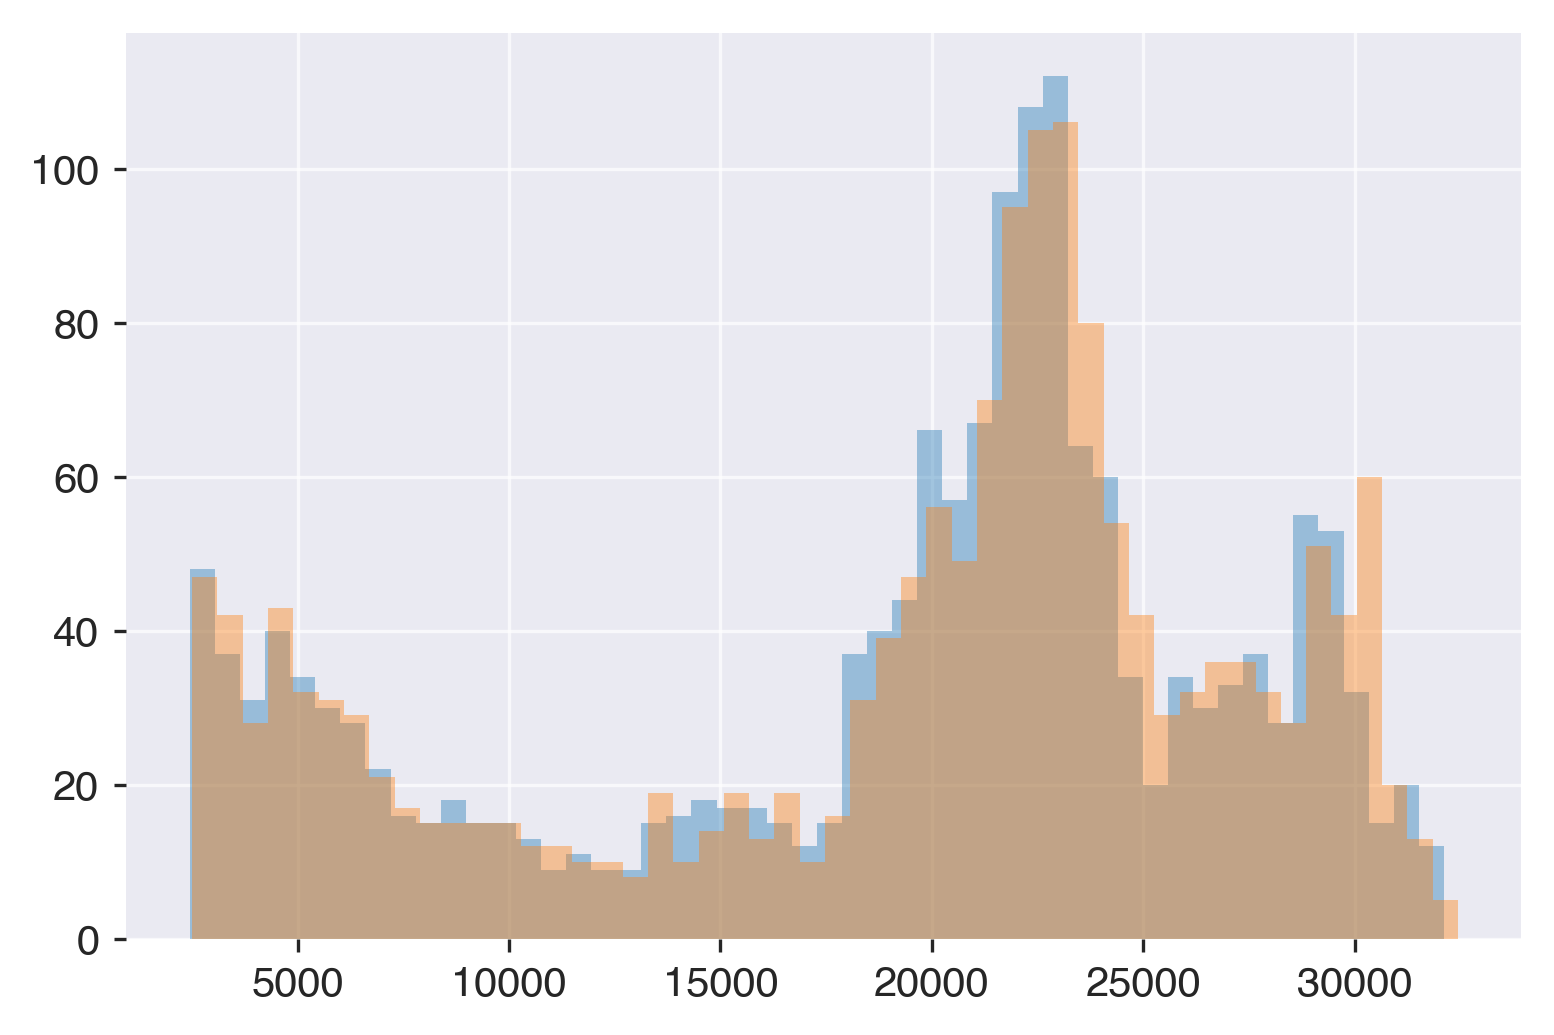

In [37]:
sns.distplot(dropoff_counts.ravel(), bins=50, kde=False)
sns.distplot(pickup_counts.ravel(), bins=50, kde=False)

In [38]:
np.percentile(pickup_counts.ravel(), q=np.linspace(0, 95, 20)).round(-2)

array([  2500.,   3700.,   5000.,   6800.,   9800.,  13800.,  17300.,
        19200.,  20200.,  21200.,  21800.,  22400.,  22800.,  23300.,
        23800.,  24700.,  26200.,  27600.,  29100.,  30200.])

In [39]:
np.percentile(pickups_rescaled.ravel(), q=np.linspace(0, 95, 20))

array([ 0.00654762,  0.05252078,  0.10192208,  0.1519059 ,  0.20098576,
        0.2502767 ,  0.30041888,  0.35185058,  0.40224649,  0.45543863,
        0.50433921,  0.55609425,  0.60453845,  0.65653499,  0.70567315,
        0.7533645 ,  0.80186527,  0.85113581,  0.90313963,  0.95554029])

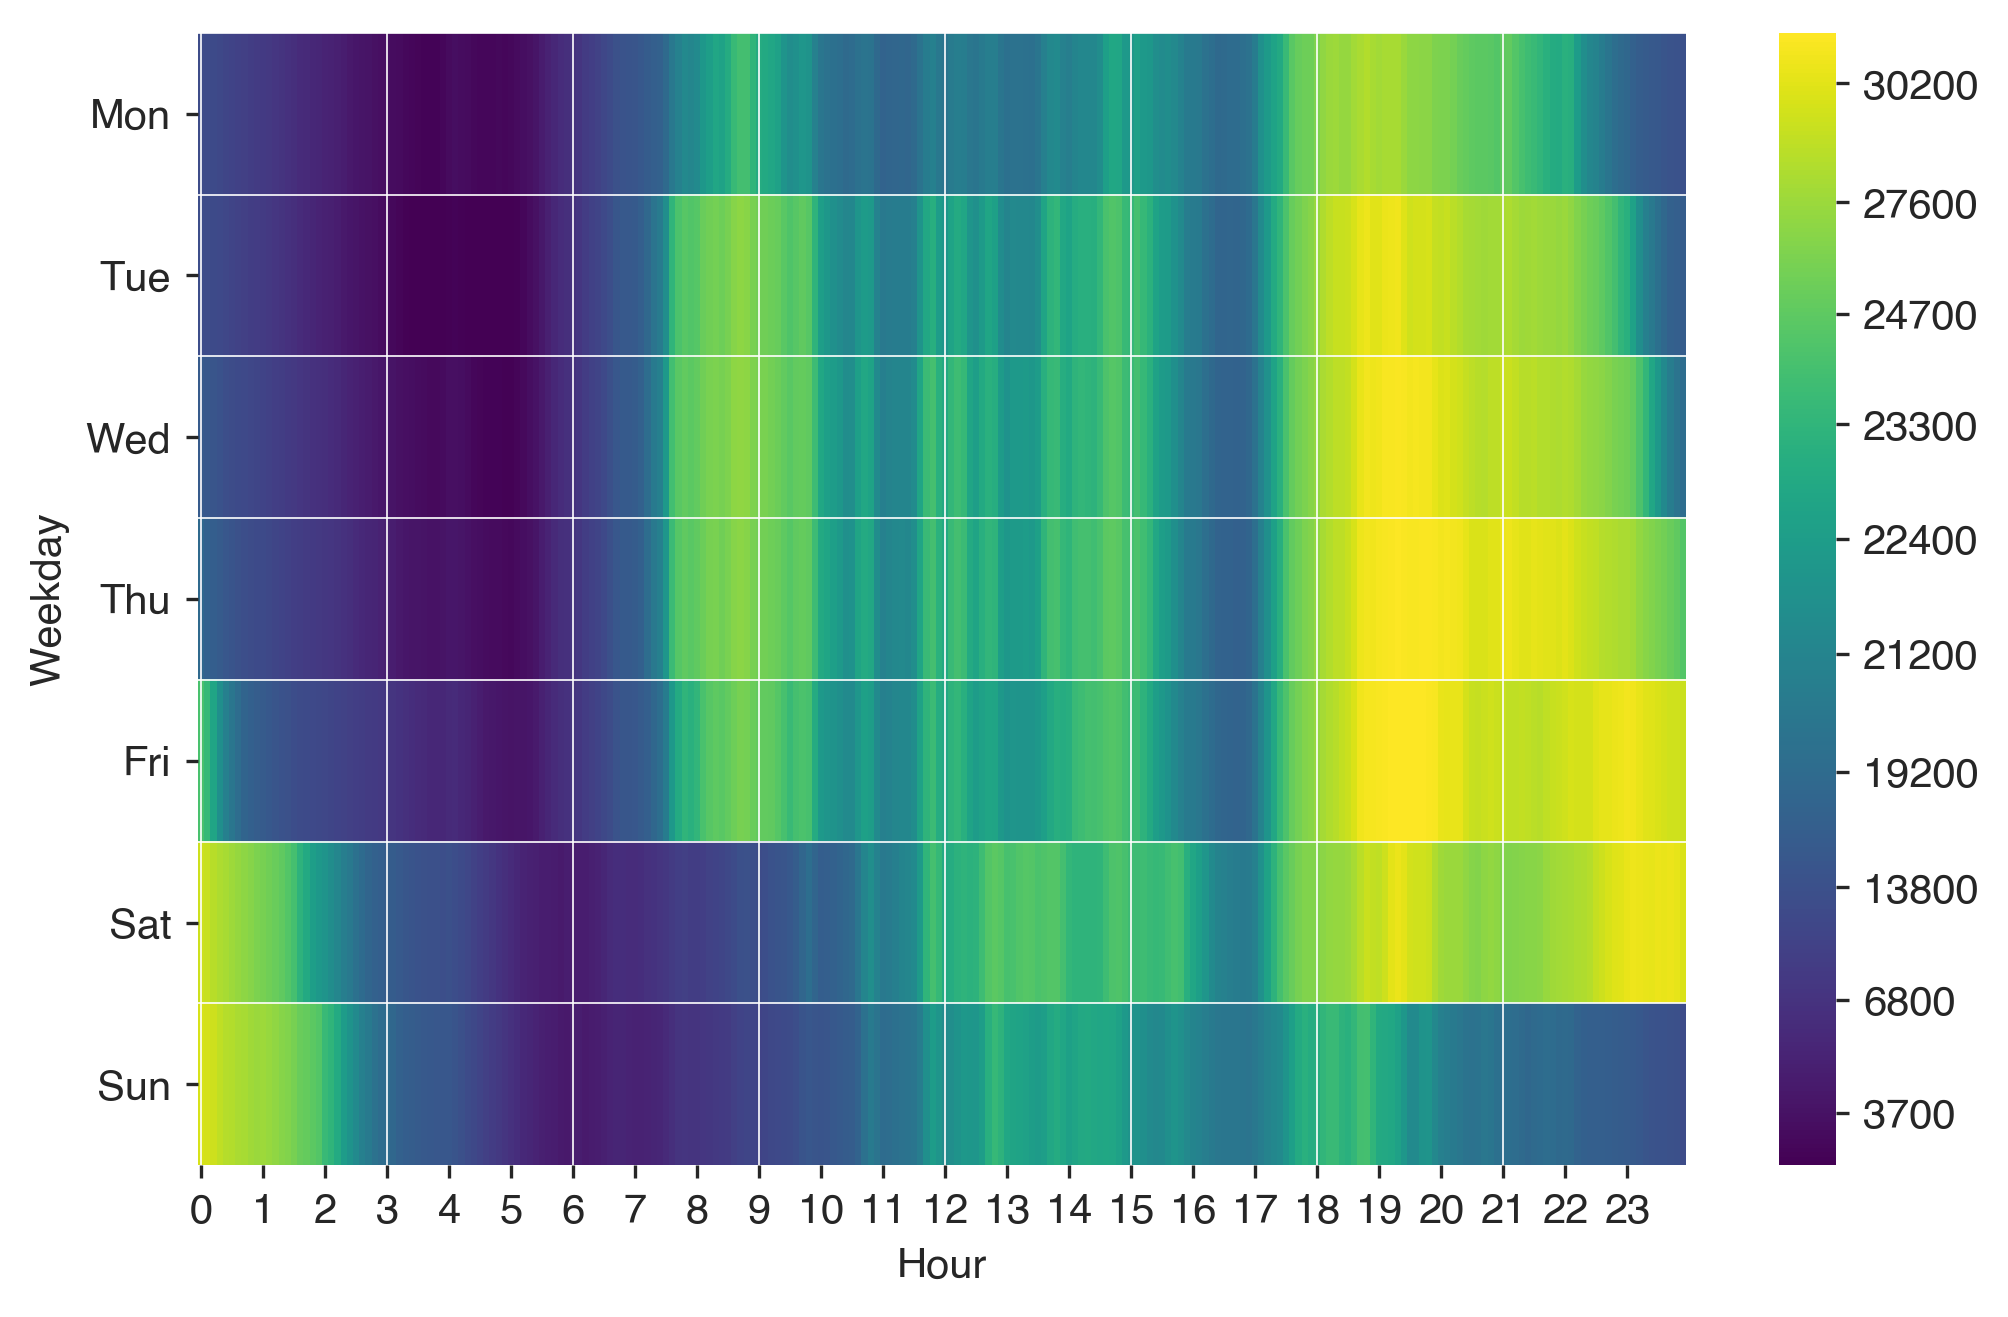

In [40]:
plt.imshow(pickups_rescaled.T, aspect='auto', interpolation='none', cmap=plt.cm.viridis)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')
cb.set_ticks(np.percentile(pickups_rescaled.ravel(), q=np.arange(5, 100, 10)))
cb.set_ticklabels((np.percentile(pickup_counts.ravel(), q=np.arange(5, 100, 10)).round(-2)).astype(int).astype(str))

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.arange(0, 240, 10))
plt.gca().xaxis.set_ticklabels([str(x) for x in range(0, 24)])
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='w', lw=0.4)
for i in range(0, 240, 30):
    plt.axvline(i, color='w', lw=0.4)

(0, 240)

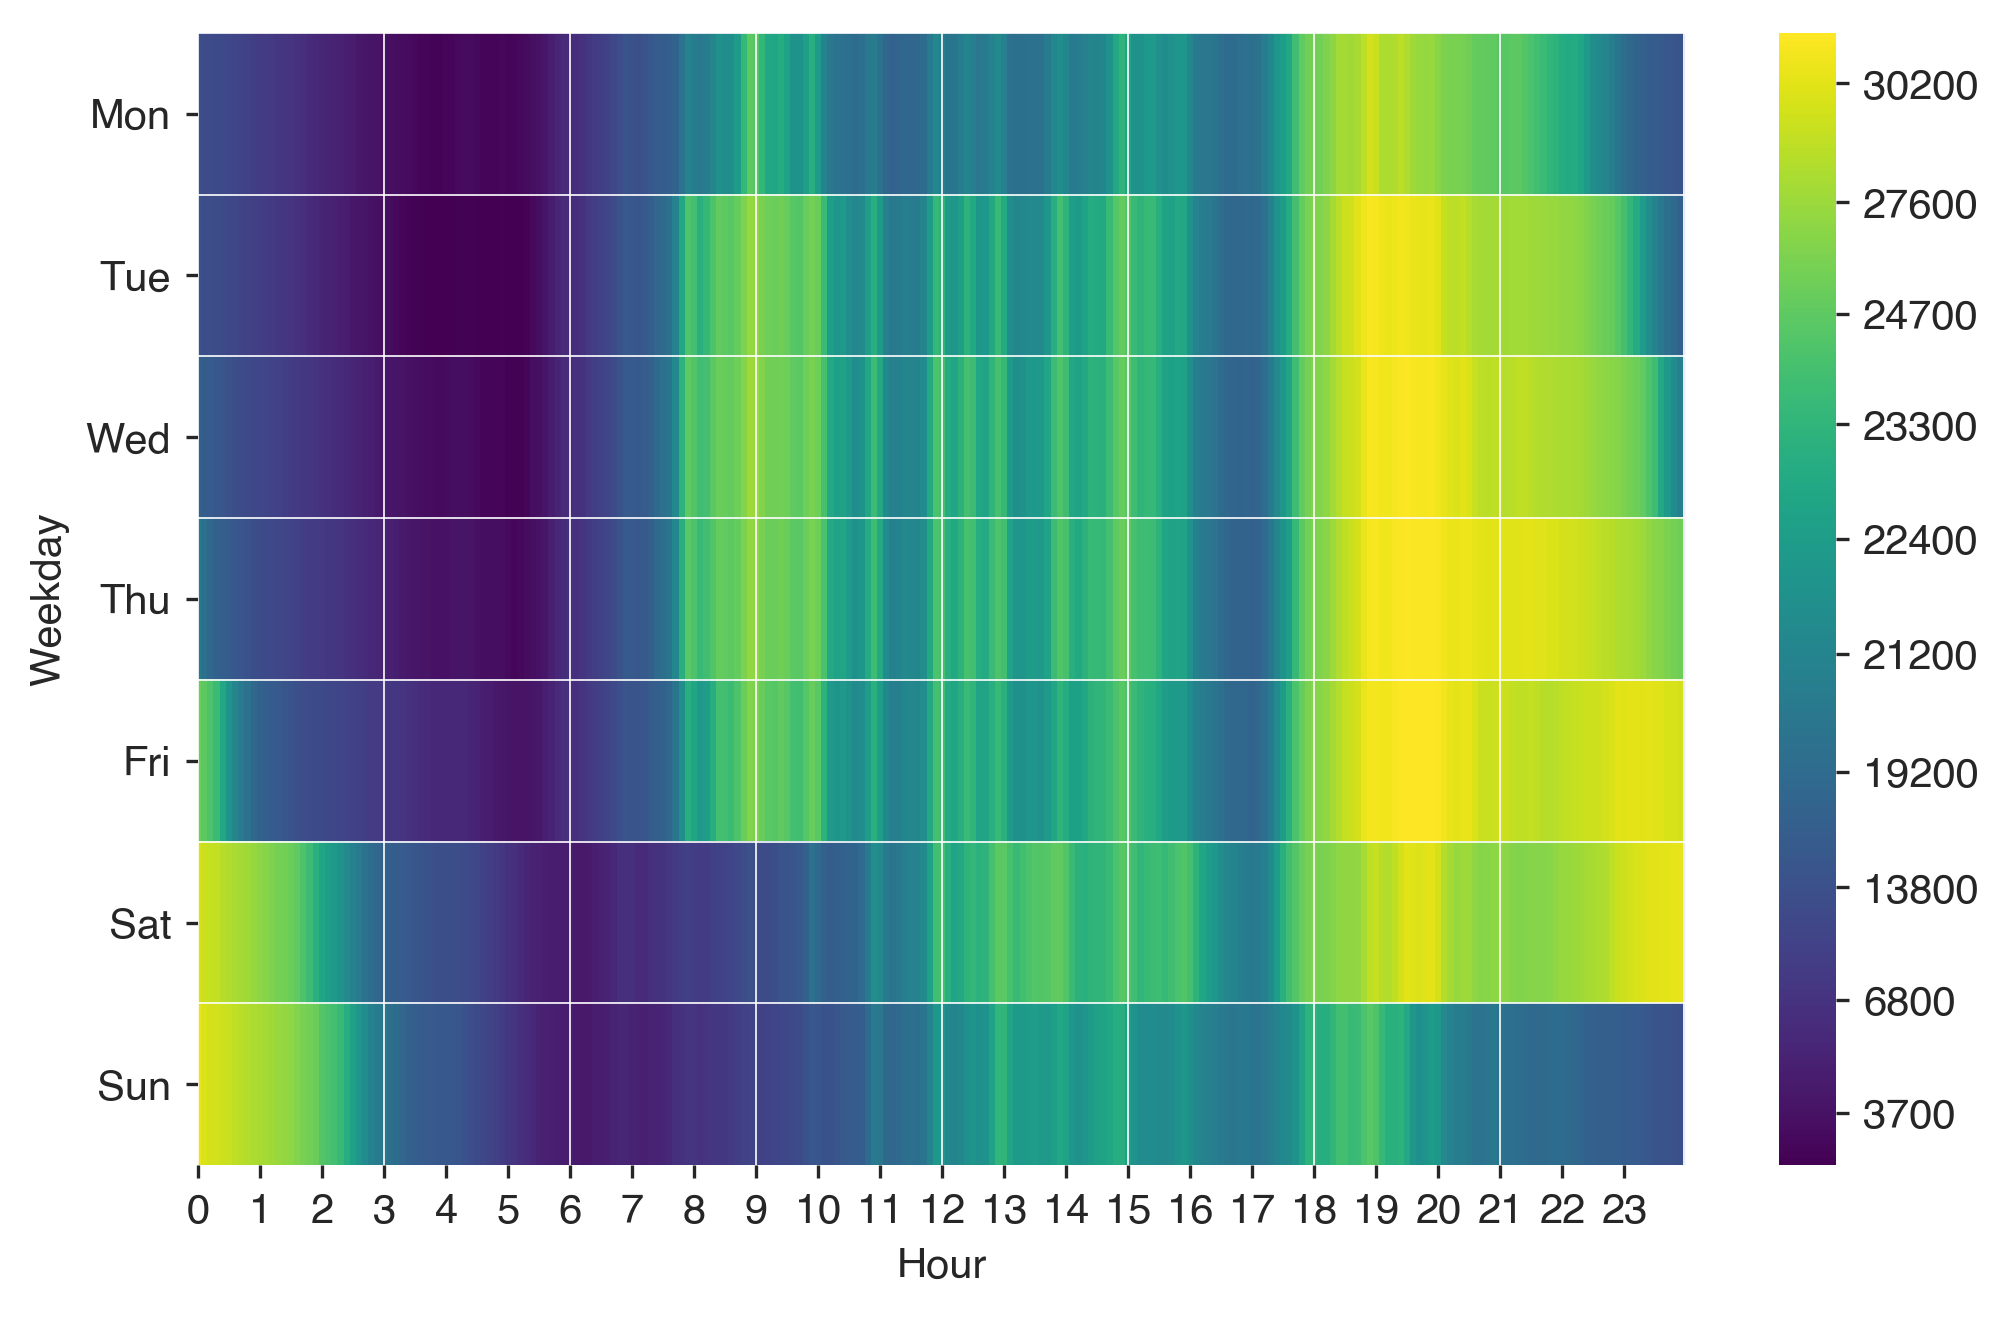

In [41]:
plt.imshow(dropoffs_rescaled.T, aspect='auto', interpolation='none', cmap=plt.cm.viridis)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')
cb.set_ticks(np.percentile(pickups_rescaled.ravel(), q=np.arange(5, 100, 10)))
cb.set_ticklabels((np.percentile(pickup_counts.ravel(), q=np.arange(5, 100, 10)).round(-2)).astype(int).astype(str))

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.arange(0, 240, 10))
plt.gca().xaxis.set_ticklabels([str(x) for x in range(0, 24)])
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='w', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='2', lw=0.4)
plt.xlim(0, 240)

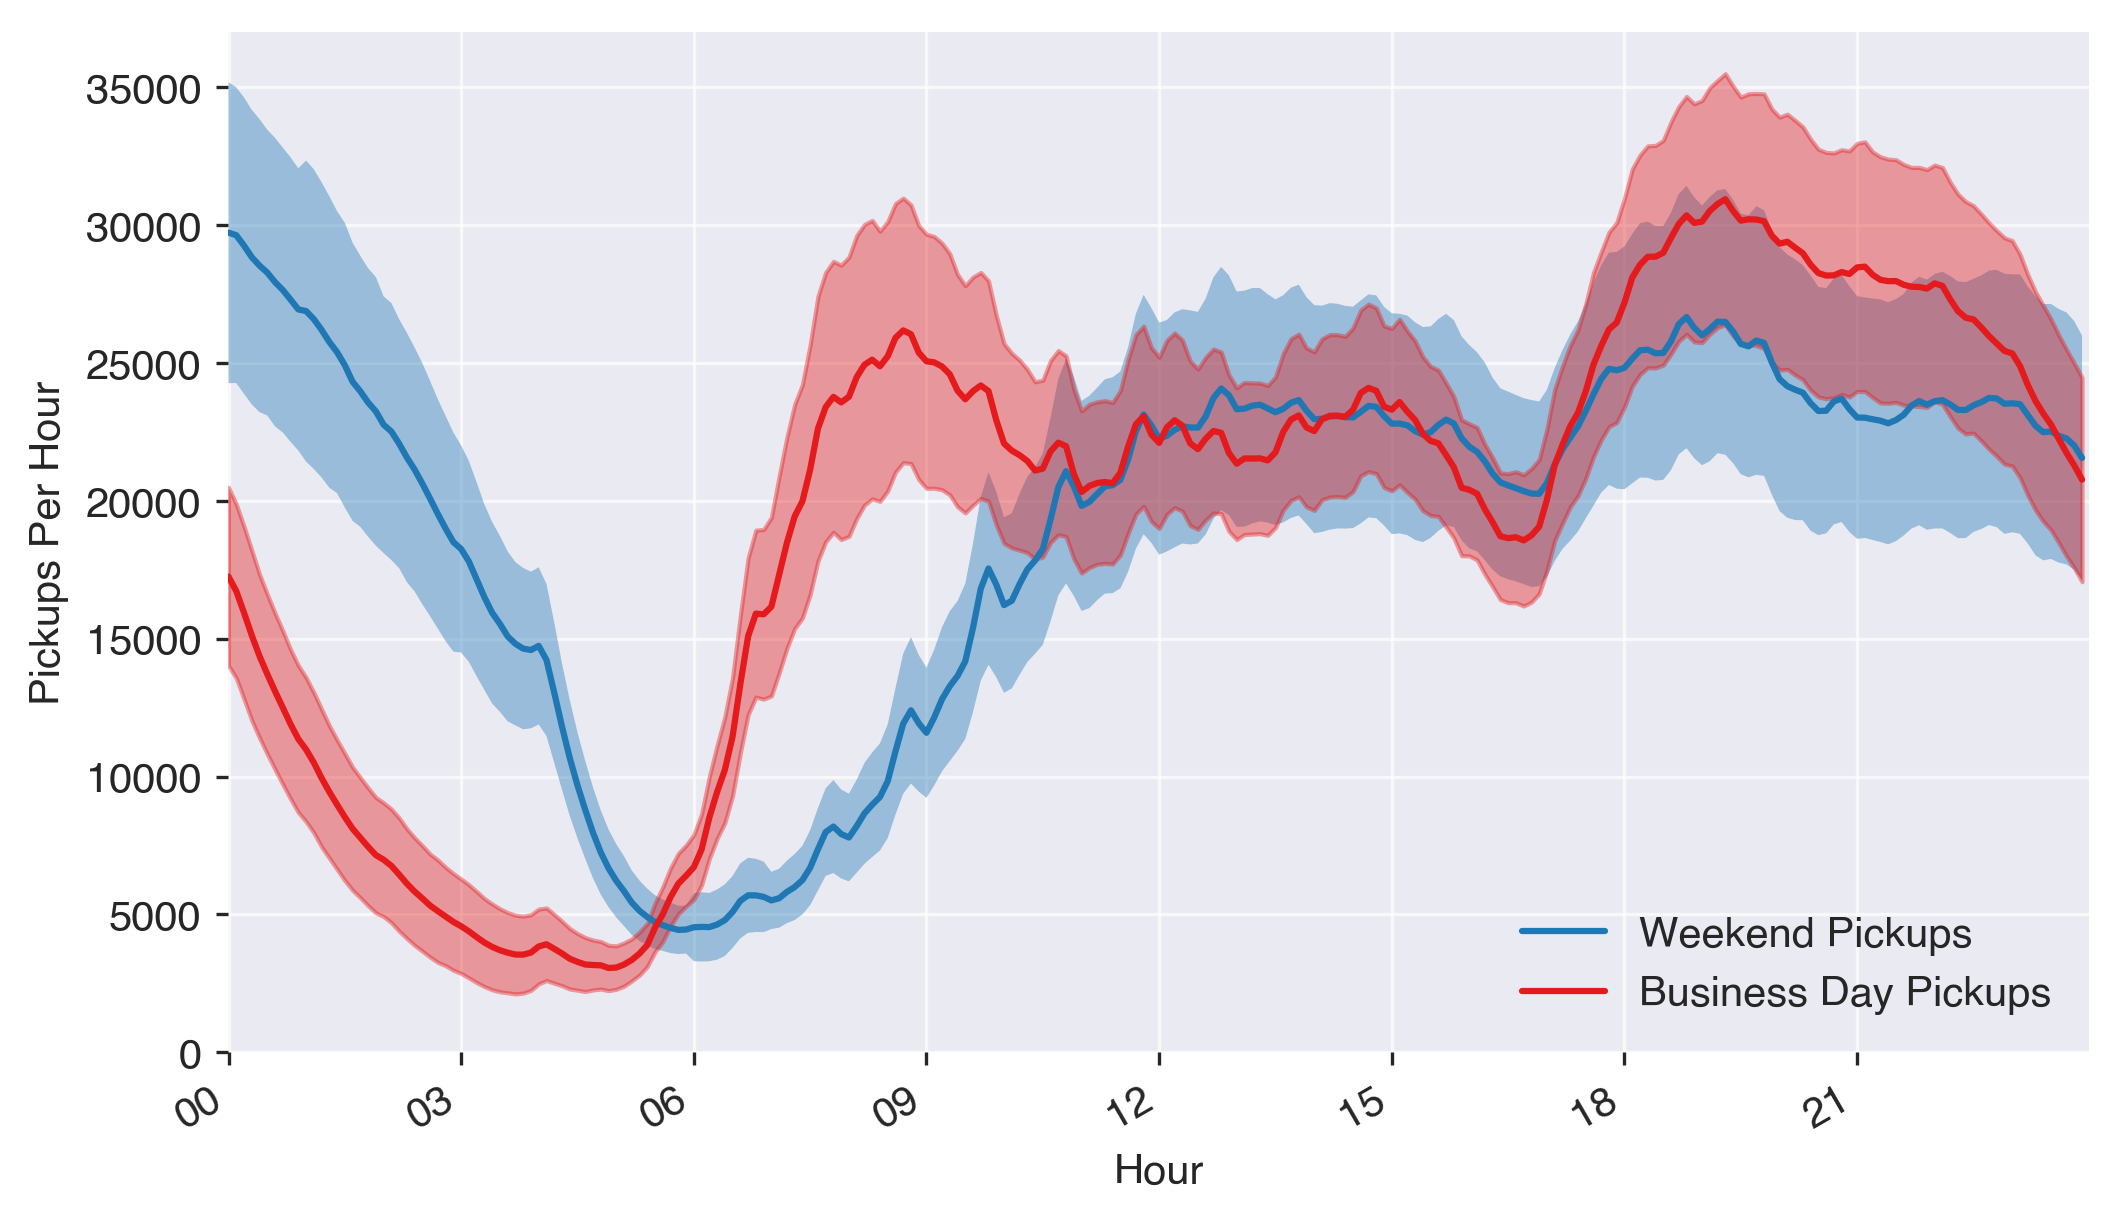

In [42]:
# plt.plot(pd.date_range('00:00', '23:54', freq='6T').values, (pickup_counts)[:, :5])

xv = pd.date_range('00:00', '23:54', freq='6T').values

plt.fill_between(xv, np.mean((pickup_counts)[:, 5:], axis=1) + np.mean((pickup_counts_std)[:, 5:], axis=1),
                np.mean((pickup_counts)[:, 5:], axis=1) - np.mean((pickup_counts_std)[:, 5:], axis=1), alpha=0.4)

plt.fill_between(xv, np.mean((pickup_counts)[:, :5], axis=1) + np.mean((pickup_counts_std)[:, :5], axis=1),
                np.mean((pickup_counts)[:, :5], axis=1) - np.mean((pickup_counts_std)[:, :5], axis=1), alpha=0.4,
                color='#e41a1c')

plt.plot(xv, np.mean((pickup_counts)[:, 5:], axis=1), label='Weekend Pickups')
plt.plot(xv, np.mean((pickup_counts)[:, :5], axis=1), label='Business Day Pickups', color='#e41a1c')

# plt.plot(pd.date_range('00:00', '23:54', freq='6T').values, np.mean((dropoff_counts)[:, :5], axis=1), label='Business Day Pickups')
# plt.plot(pd.date_range('00:00', '23:54', freq='6T').values, np.mean((dropoff_counts)[:, 5:], axis=1), label='Weekend Pickups')

plt.gcf().set_size_inches(8, 5)
plt.xlim('00:00', '23:59')
plt.legend(loc='lower right')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_ticks(pd.date_range('00:00', '23:54', freq='3H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('00:00', '23:54', freq='3H').strftime('%H'))
plt.ylim(0, 37000)

plt.xlabel("Hour")
plt.ylabel("Pickups Per Hour")

In [43]:
import scipy.stats
scipy.stats.describe((pickup_counts - dropoff_counts).ravel())

DescribeResult(nobs=1680, minmax=(-2290.8867, 4040.959), mean=294.97668, variance=1023472.8, skewness=0.6273531317710876, kurtosis=0.41672306562037686)

(0, 240)

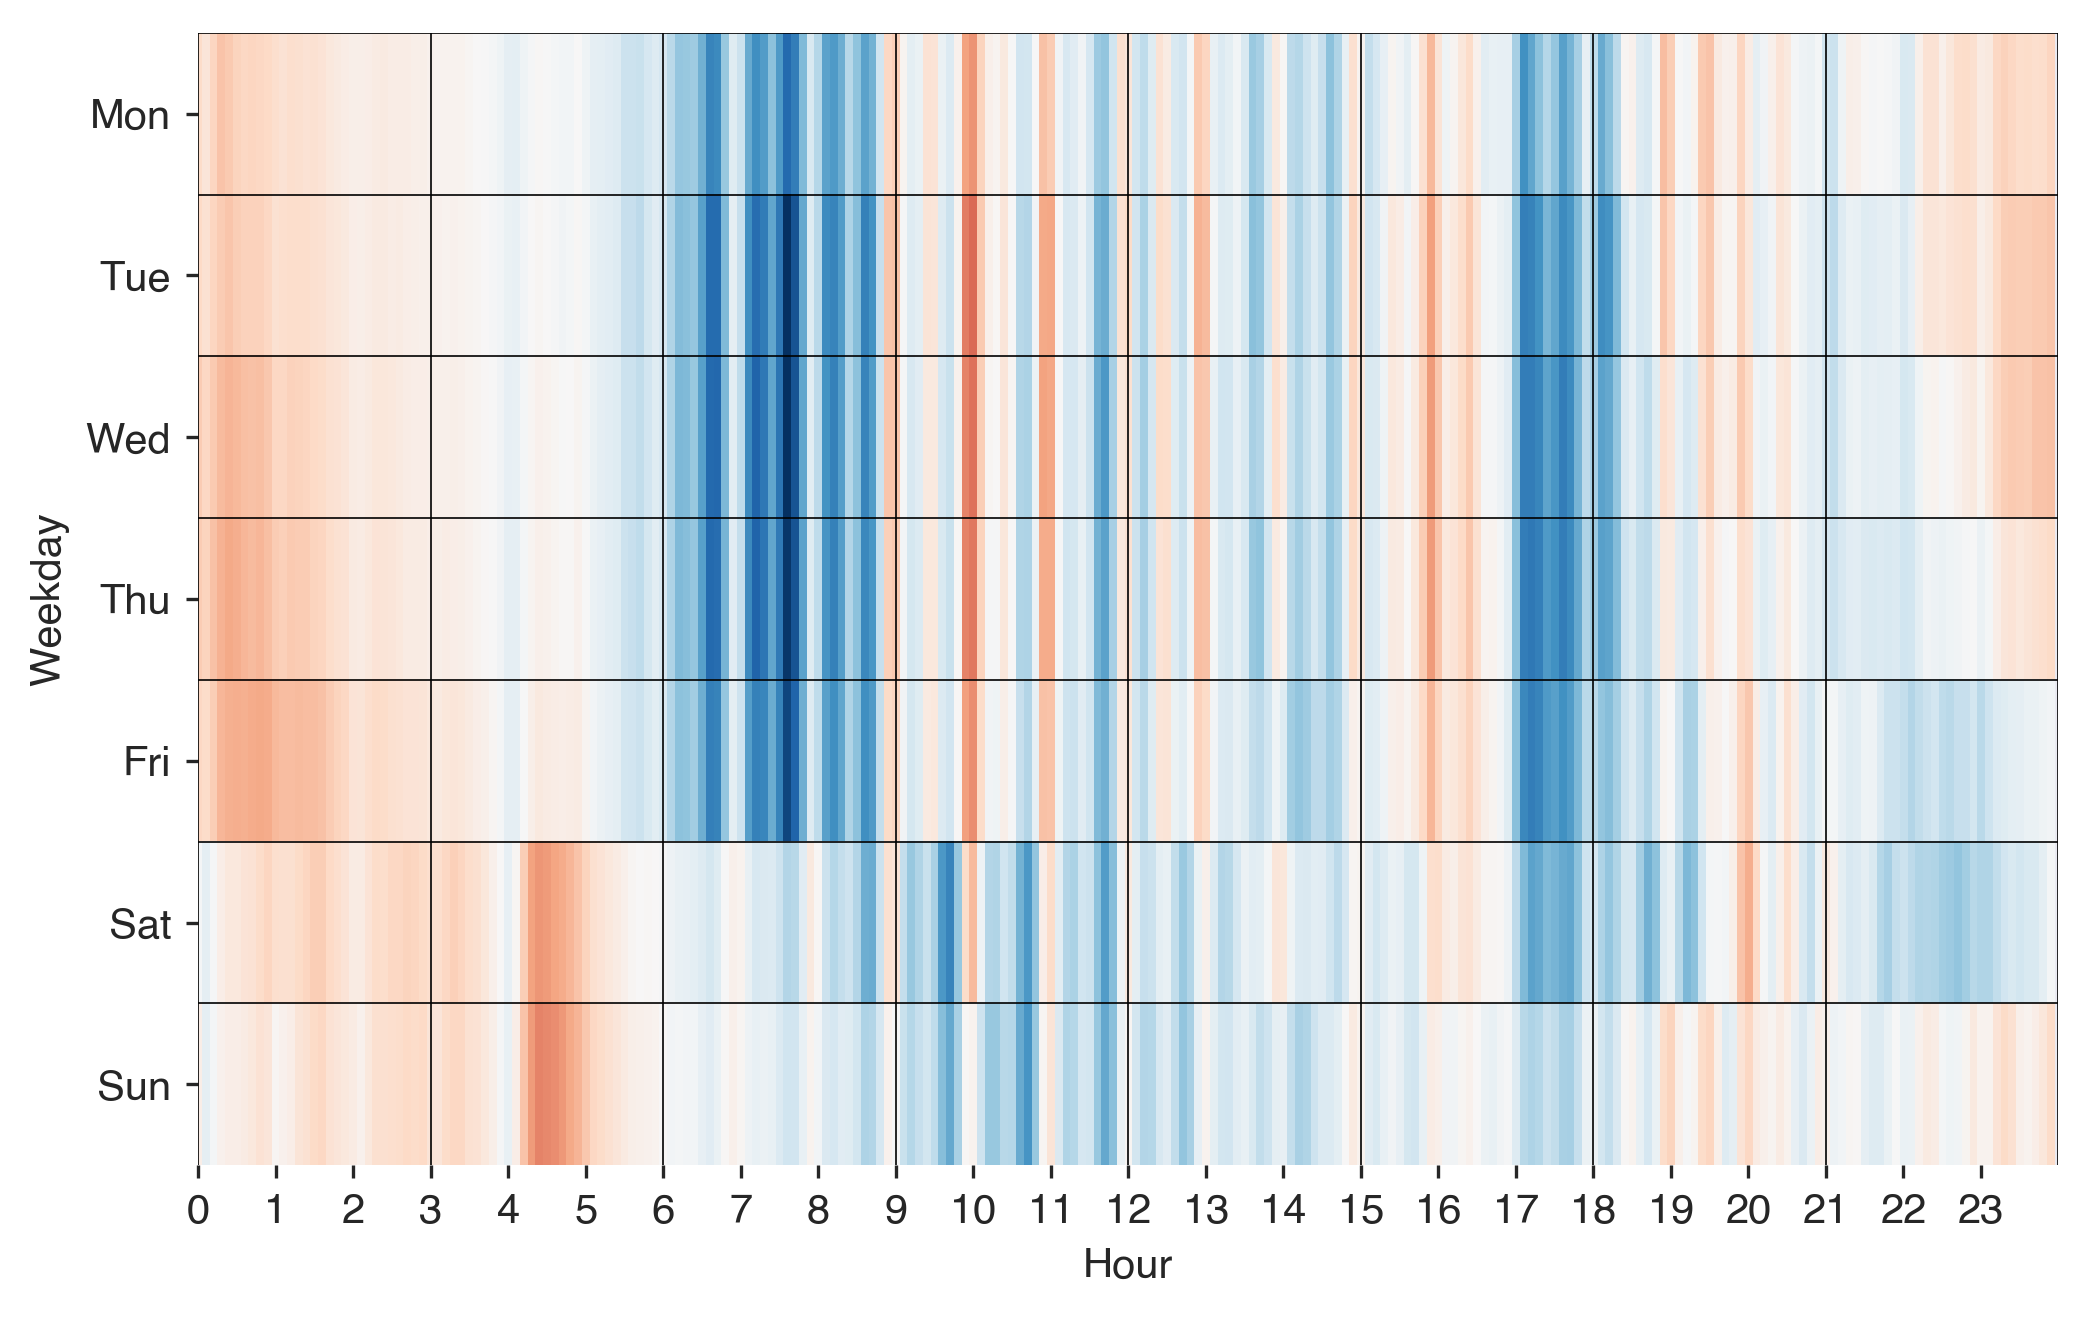

In [44]:
plt.imshow((pickup_counts - dropoff_counts).T, aspect='auto', cmap=plt.cm.RdBu, vmin=-4041, vmax=4041)
plt.gcf().set_size_inches(8, 5)

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.arange(0, 240, 10))
plt.gca().xaxis.set_ticklabels([str(x) for x in range(0, 24)])
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='k', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='k', lw=0.4)
plt.xlim(0, 240)

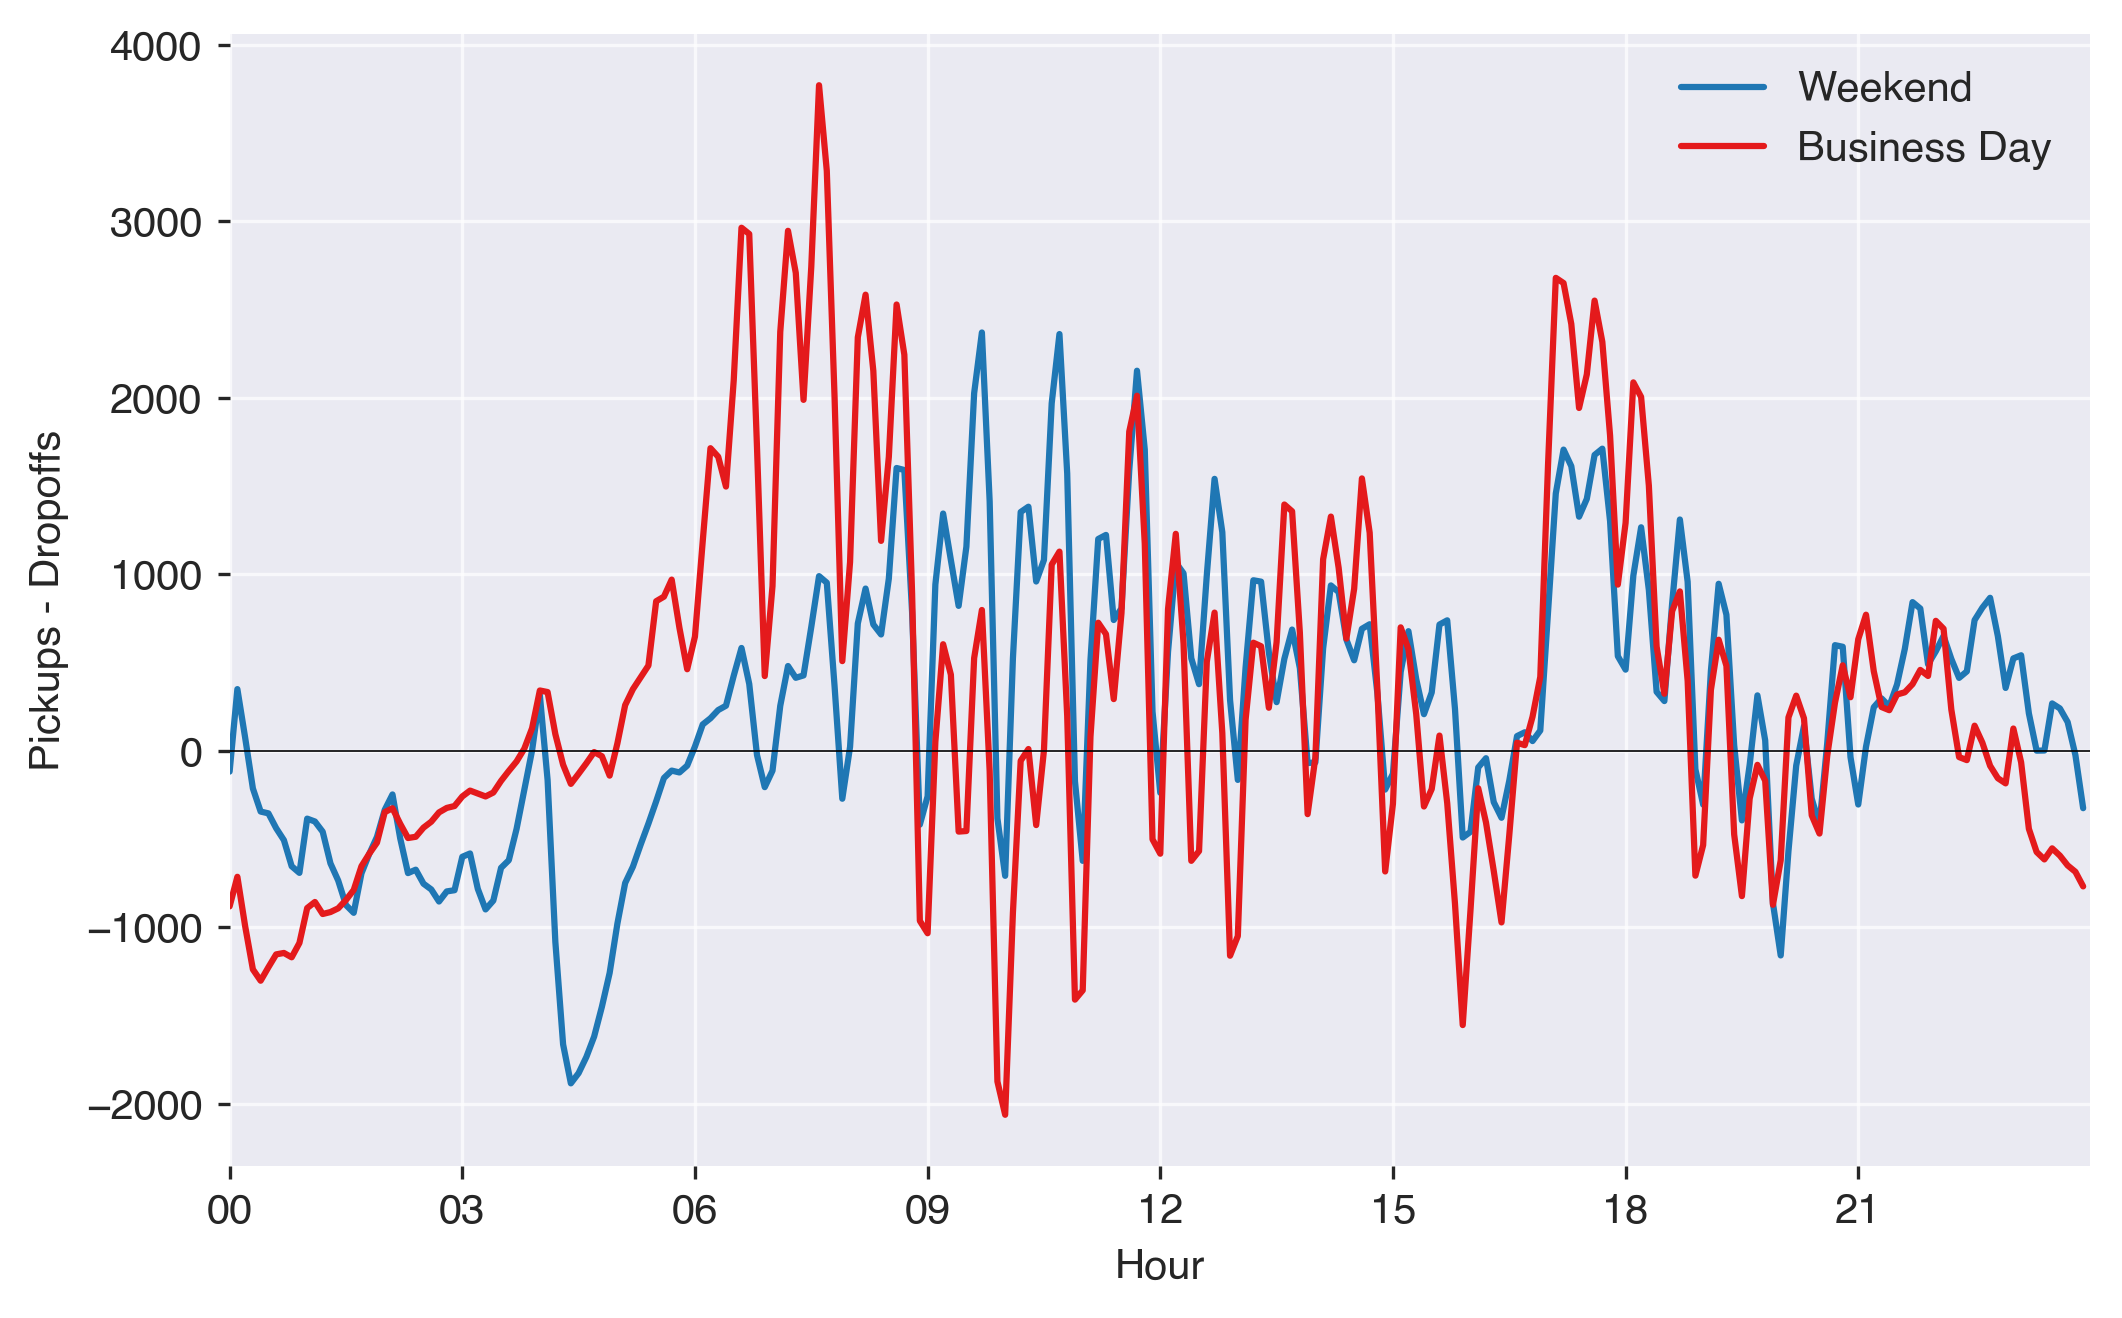

In [45]:
plt.plot(pd.date_range('00:00', '23:54', freq='6T').values, np.mean((pickup_counts - dropoff_counts)[:, 5:], axis=1),
         label='Weekend')
plt.plot(pd.date_range('00:00', '23:54', freq='6T').values, np.mean((pickup_counts - dropoff_counts)[:, :5], axis=1), 
         color='#e41a1c', 
         label='Business Day')

plt.legend(loc='upper right')

plt.gca().xaxis.set_ticks(pd.date_range('00:00', '23:54', freq='3H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('00:00', '23:54', freq='3H').strftime('%H'))

plt.gcf().set_size_inches(8, 5)
plt.axhline(0, color='k', lw=0.4)
plt.xlim('00:00', '23:59')
plt.xlabel("Hour")
plt.ylabel("Pickups - Dropoffs")

# Trends

In [24]:
import statsmodels.api as sm

/home/shekhar/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [25]:
heatmap_all_dropoffs_all = (dropoffs[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']] \
                            .groupby(['dayofweek', 'timeofday', 'weeks_since_2009']).count().compute())

In [51]:
grouped = heatmap_all_dropoffs_all.reset_index().groupby(['dayofweek', 'timeofday'])

rows = []

for group in grouped.groups.keys():
    df = grouped.get_group(group)
    df['constant']=1
    X = df[['weeks_since_2009','constant']]
    y = df['id']
    model = sm.RLM(y,X)
    results = model.fit()
    
    rows.append(group + (results.params.weeks_since_2009, results.params.constant))


/home/shekhar/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [52]:
df_pickup_trend_slopes = pd.DataFrame.from_records(rows, columns=['dayofweek', 'timeofday', 'slope', 'intercept']).sort_values(['dayofweek', 'timeofday'])

In [53]:
df_pickup_trend_slopes

,dayofweek,timeofday,slope,intercept
1080,0,0.0,0.165876,1330.513529
1615,0,0.1,-0.201280,1336.960327
644,0,0.2,-0.184510,1293.322507
335,0,0.3,-0.189360,1242.450899
894,0,0.4,-0.184983,1174.725348
1003,0,0.5,-0.186054,1111.857629
694,0,0.6,-0.169551,1053.570767
802,0,0.7,-0.158935,1008.445763
1202,0,0.8,-0.140972,949.692544
465,0,0.9,-0.101533,895.650976


In [55]:
pickup_trends = np.zeros((240, 7), dtype=np.float32) 

for weekday in range(7):
    pickup_trends[:, weekday] = df_pickup_trend_slopes[df_pickup_trend_slopes.dayofweek == weekday].slope.values * 10 * 52 # convert units into counts per hour

In [56]:
pickups_trend_rescaled = exposure.equalize_hist(pickup_trends)

(0, 240)

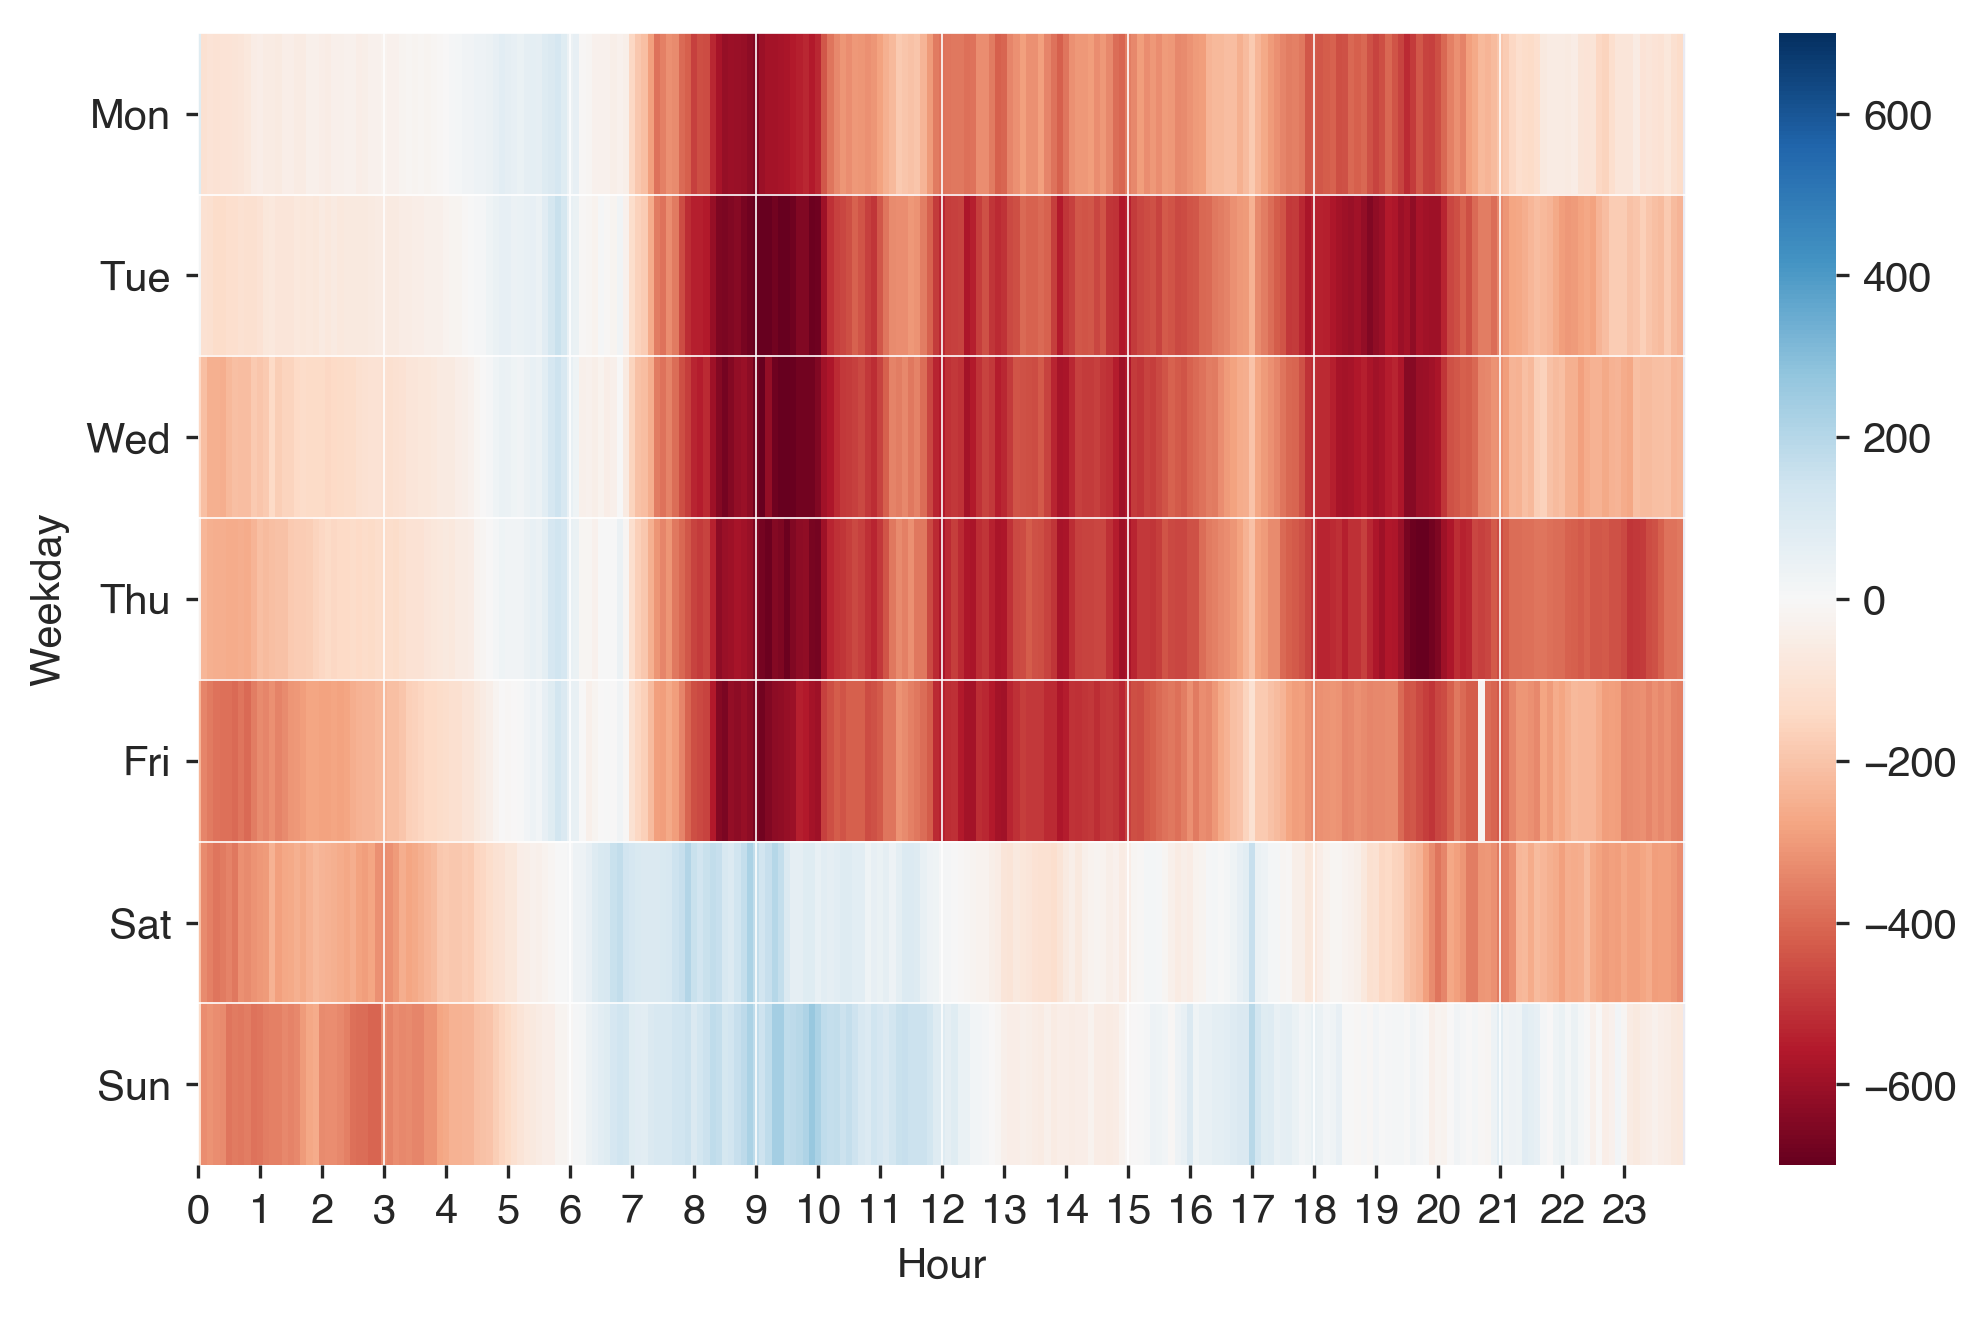

In [58]:
plt.imshow(pickup_trends.T, aspect='auto', interpolation='none', cmap=plt.cm.RdBu, vmin=-700, vmax=700)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')
# cb.set_ticks(np.percentile(pickup_trends.ravel(), q=np.arange(5, 100, 10)))
# cb.set_ticklabels((np.percentile(pickup_trends.ravel(), q=np.arange(5, 100, 10)).round(-2)).astype(int).astype(str))

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.arange(0, 240, 10))
plt.gca().xaxis.set_ticklabels([str(x) for x in range(0, 24)])
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='w', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='2', lw=0.4)
plt.xlim(0, 240)